# Implementation of ε-Greedy, UCB, LinUCB, Contextual Bandits and Kernel UCB; Multi-armed Bandits

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [2]:
class MAB(ABC):
    
    @abstractmethod
    def play(self, tround, context):
        # Current round of t (for my implementations average mean reward array 
        # at round t is passed to this function instead of tround itself)
        self.tround = tround
        # Context: features of contextual bandits
        self.context = context
        # choose an arm which yields maximum value of average mean reward, tie breaking randomly
        chosen_arm = np.random.choice(np.where(self.tround==max(self.tround))[0])
        return chosen_arm
        pass
        
    
    @abstractmethod
    def update(self, arm, reward, context):
        # get the chosen arm
        self.arm = arm
        # get the context (may be None)
        self.context = context
        # update the overall step of the model
        self.step_n += 1
        # update the step of individual arms
        self.step_arm[self.arm] += 1
        # update average mean reward of each arm
        self.AM_reward[self.arm] = ((self.step_arm[self.arm] - 1) / float(self.step_arm[self.arm]) 
        * self.AM_reward[self.arm] + (1 / float(self.step_arm[self.arm])) * reward)
        return
        pass

In [3]:
class EpsGreedy(MAB):
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        # Set number of arms
        self.narms = narms
        # Exploration probability
        self.epsilon = epsilon
        # Q0 values
        self.Q0 = np.ones(self.narms)*np.inf
        # Total step count
        self.step_n = 0
        # Step count for each arm
        self.step_arm = np.zeros(self.narms)
        # Mean reward for each arm
        self.AM_reward = np.zeros(self.narms)
        super().__init__()
        return
        
    # Play one round and return the action (chosen arm)
    def play(self, tround, context=None):
        # Generate random number
        p = np.random.rand()
        
        if self.epsilon == 0 and self.step_n == 0:
            action = np.random.choice(self.narms)
        elif p < self.epsilon:
            action = np.random.choice(self.narms)
        else:
            # Q0 values are initially set to np.inf. Hence, choose an arm with maximum Q0 value (
            # for all of them is np.inf, and therefore will play all of the arms at least one time)

            if len(np.where(self.Q0==0)[0])<10:
                # choose an arm with maximum Q0 value
                action = np.random.choice(np.where(self.Q0==max(self.Q0))[0])
                # after the arm is chosen, set the corresponding Q0 value to zero
                self.Q0[action]=0
            else:
                # Now, after that we ensure that there is no np.inf in Q0 values and all of them are set to zero
                # we return to play based on average mean rewards
                action = super(EpsGreedy, self).play(self.AM_reward, context)
        # np.argmax returns values 0-9, we want to compare with arm indices in dataset which are 1-10
        # Hence, add 1 to action before returning
        return action+1
    
        
    def update(self, arm, reward, context=None):
        super(EpsGreedy, self).update(arm, reward, context)
        return

In [4]:
class UCB(MAB):
    
    def __init__(self, narms, rho, Q0=np.inf):
        # Set number of arms
        self.narms = narms
        # Rho
        self.rho = rho
        # Q0 values
        self.Q0 = np.ones(self.narms)*np.inf
        # Total step count
        self.step_n = 0
        # Step count for each arm
        self.step_arm = np.zeros(self.narms)
        # Mean reward for each arm
        self.AM_reward = np.zeros(self.narms)
        super().__init__()
        return

    # Play one round and return the action (chosen arm)
    def play(self, tround, context=None):
        # Q0 values are initially set to np.inf. Hence, choose an arm with maximum Q0 value (
        # for all of them is np.inf, and therefore will play all of the arms at least one time)
            
        if len(np.where(self.Q0==0)[0])<10:
            # choose an arm with maximum Q0 value
            action = np.random.choice(np.where(self.Q0==max(self.Q0))[0])
            # after the arm is chosen, set the corresponding Q0 value to zero
            self.Q0[action]=0
        else:
            # Now, after that we ensure that there is no np.inf in Q0 values and all of them are set to zero
            # we return to play based on average mean rewards
            
            # construct UCB values which performs the sqrt part
            ucb_values = np.zeros(self.narms)
            for arm in range(self.narms):
                if self.step_arm[arm]>0:
                    ucb_values[arm]= np.sqrt(self.rho *(np.log(self.step_n)) / self.step_arm[arm])
            action = super(UCB, self).play(self.AM_reward + ucb_values, context)
        # np.argmax returns values 0-9, we want to compare with arm indices in dataset which are 1-10
        # Hence, add 1 to action before returning     
        return action+1
        
        
    def update(self, arm, reward, context=None):
        super(UCB, self).update(arm, reward, context)
        return

## 2. Off-Policy Evaluation

In [5]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    # array to contain chosen arms in offline mode
    chosen_arms = np.zeros(nrounds)
    # rewards of each chosen arm
    reward_arms = np.zeros(nrounds)
    # cumulative reward at each iteration
    cumulative_reward = np.zeros(nrounds)
    # initialize tround to zero
    T = 0
    # initialize overall cumulative reward to zero
    G = 0
    # History or memory of offline evaluator
    history = []
    # play once and get the initial action
    action = mab.play(T, contexts[0,:])
    
    #===============================
    #    MAIN LOOP ...
    #===============================
    for i in range(np.shape(data)[0]):
        action = mab.play(T, contexts[i,:])
        if T<nrounds:
            # update parameters and play only when chosen arm from bandit matches data
            if action == arms[i]:
                # append the current context of chosen arm to the previous history (list)
                history.append(contexts[i,:])
                # get the reward of chosen arm at round T
                reward_arms[T] = rewards[i]
                # the returned action is between 1-10, setting to python encoding ==> 0-9
                mab.update(action-1, rewards[i], contexts[i,:])
                # update overall cumulative reward
                G += rewards[i]
                # update cumulative reward of round T 
                cumulative_reward[T] = G
                # store chosen arm at round T
                chosen_arms[T] = action
                T +=1
        else:
            # if desired tround ends, terminate the loop
            break
    return reward_arms, chosen_arms, cumulative_reward

In [6]:
# load dataset and initialize arms, rewards and contexts arrays
data = np.loadtxt('./dataset.txt')
arms = data[:,0]
rewards = data[:,1]
contexts = data[:,2:102]
mab = EpsGreedy(10, 0.05)
results_EpsGreedy, chosen_arms_EpsGreedy, cumulative_reward_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.185


In [7]:
mab = UCB(10, 1.0)
results_UCB, chosen_arms_UCB, cumulative_reward_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.14625


## 3. Contextual Bandits

In [8]:
class LinUCB(MAB):
    
    def __init__(self, narms, ndims, alpha):
        # Set number of arms
        self.narms = narms
        # Number of context features
        self.ndims = ndims
        # explore-exploit parameter
        self.alpha = alpha
        # Instantiate A as a ndims×ndims matrix for each arm
        self.A = np.zeros((self.narms, self.ndims, self.ndims))
        # Instantiate b as a 0 vector of length ndims.
        self.b = np.zeros((narms, self.ndims, 1))
        # set each A per arm as identity matrix of size ndims
        for arm in range(self.narms):
            self.A[arm] = np.eye(self.ndims)
        
        super().__init__()
        return
        
    def play(self, tround, context):
        # gains per each arm
        p_t = np.zeros(self.ndims)
        
        #===============================
        #    MAIN LOOP ...
        #===============================
        for i in range(self.ndims):
            # initialize theta hat
            self.theta = inv(self.A[i]).dot(self.b[i])
            # get context of each arm from flattened vector of length 100
            cntx = context[i*10:(i+1)*10]
            # get gain reward of each arm
            p_t[i] = self.theta.T.dot(cntx
                ) + self.alpha * np.sqrt(
            cntx.dot(inv(self.A[i]).dot(cntx)))
        action = np.random.choice(np.where(p_t==max(p_t))[0])
        # np.argmax returns values 0-9, we want to compare with arm indices in dataset which are 1-10
        # Hence, add 1 to action before returning
        return action+1
        
    
    def update(self, arm, reward, context):
        self.A[arm] = self.A[arm] + np.outer(context[arm*10:(arm+1)*10],context[arm*10:(arm+1)*10])
        self.b[arm] = np.add(self.b[arm].T, context[arm*10:(arm+1)*10]*reward).reshape(self.ndims,1)
        return

In [9]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB, chosen_arms_LinUCB, cumulative_reward_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Evaluation
### 4.A.
In order to evaluate models and plot the running per-round cumulative reward per round, I propose to run each model 1000 times (except LinUCB which yields same reward per specific alpha value), and then get average of these rounds as plot. However, I have implemented only one simulation first and have showed the results. Here we go ...

EpsGreedy average reward 0.2475
UCB average reward 0.1525
LinUCB average reward 0.53


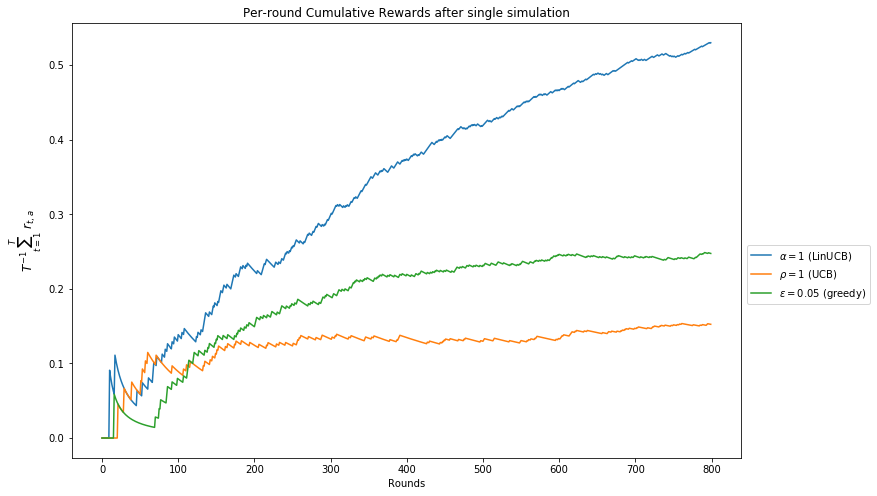

In [18]:
                                #===============================
                                #    single simulation ...
                                #===============================

#===============================
#    Epsilon Greedy ...
#===============================
mab = EpsGreedy(10, 0.05)
results_EpsGreedy, chosen_arms_EpsGreedy, cumulative_reward_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

#===============================
#    UCB ...
#===============================
mab = UCB(10, 1.0)
results_UCB, chosen_arms_UCB, cumulative_reward_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

#===============================
#    Linear UCB (Contextual) ...
#===============================
mab = LinUCB(10, 10, 1.0)
results_LinUCB, chosen_arms_LinUCB, cumulative_reward_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

#===============================
#    Plotting results ...
#===============================

plt.figure(figsize=(12,8))
plt.plot(cumulative_reward_LinUCB/np.linspace(1,800,800), label = r"$\alpha=1$ (LinUCB)")
plt.plot(cumulative_reward_UCB/(np.linspace(1,800,800)), label = r"$\rho=1$ (UCB)")
plt.plot(cumulative_reward_EpsGreedy/(np.linspace(1,800,800)), label = r"$\epsilon=0.05$ (greedy)")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Rounds")
plt.ylabel(r"$T^{-1}\sum_{t=1}^T\ r_{t,a}$", fontsize='large')
plt.title("Per-round Cumulative Rewards after single simulation")
plt.show()

EpsGreedy average reward 0.22032875000000005
UCB average reward 0.18377749999999998
LinUCB average reward 0.53


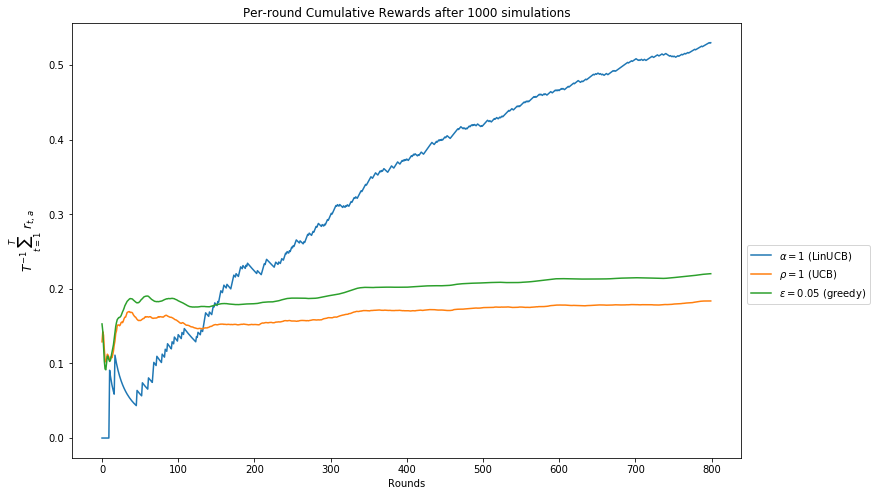

In [19]:
                                #===============================
                                #    1000 simulations ...
                                #===============================

#===============================
#    Epsilon Greedy ...
#===============================
# aray to store cumulative reward of each round for 1000 runs
mean_EPSgreedy = np.zeros(800)
# aray to store average reward of each round for 1000 runs
average_results = np.zeros(800)
for i in range(1000):
    mab = EpsGreedy(10, 0.05)
    results_EpsGreedy, chosen_arms_EpsGreedy, cumulative_reward_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
    average_results += results_EpsGreedy
    mean_EPSgreedy += cumulative_reward_EpsGreedy
print('EpsGreedy average reward', np.mean(average_results/1000))

#===============================
#    UCB ...
#===============================
# aray to store cumulative reward of each round for 1000 runs
mean_UCB = np.zeros(800)
# aray to store average reward of each round for 1000 runs
average_results = np.zeros(800)
for i in range(1000):
    mab = UCB(10, 1.0)
    results_UCB, chosen_arms_UCB, cumulative_reward_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
    average_results += results_UCB
    mean_UCB += cumulative_reward_UCB
print('UCB average reward', np.mean(average_results/1000))

#===============================
#    Linear UCB (Contextual) ...
#===============================
mab = LinUCB(10, 10, 1.0)
results_LinUCB, chosen_arms_LinUCB, cumulative_reward_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

#===============================
#    Plotting results ...
#===============================

plt.figure(figsize=(12,8))
plt.plot(cumulative_reward_LinUCB/np.linspace(1,800,800), label = r"$\alpha=1$ (LinUCB)")
plt.plot(mean_UCB/(1000*np.linspace(1,800,800)), label = r"$\rho=1$ (UCB)")
plt.plot(mean_EPSgreedy/(1000*np.linspace(1,800,800)), label = r"$\epsilon=0.05$ (greedy)")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Rounds")
plt.ylabel(r"$T^{-1}\sum_{t=1}^T\ r_{t,a}$", fontsize='large')
plt.title("Per-round Cumulative Rewards after 1000 simulations")
plt.show()

### 4.B.
To obtain the optimal value of alpha regarding Linear UCB implementation, I propose to define a range of values for alpha, then implementing LinUCB per each of the alpha values, and finally find the argument of alpha which yields maximum reward. I will use offline evaluation mode for my implementations.

Best value of alpha resulting in maximum average reward is:  0.02


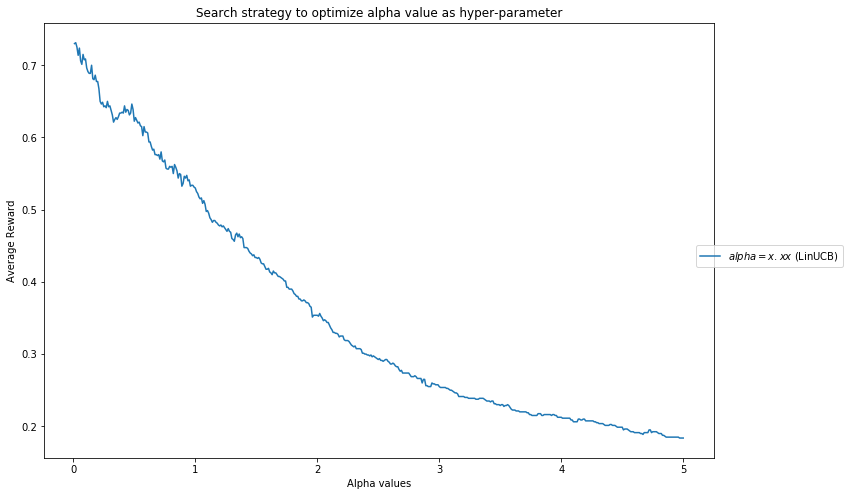

In [20]:
# array of different alpha values ranging from 0 to 5 (excluding 0 itself because alpha is member of R+) with step of .01
alphas = np.linspace(0,5,501)[1:]
# average reward of LinUCB per each alpha value
average_results = np.zeros(len(alphas))

#===============================
#    Looping alphas ...
#===============================
for alpha in range(len(alphas)):    
    mab = LinUCB(10, 10, alphas[alpha])
    results_LinUCB, chosen_arms_LinUCB, cumulative_reward_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
    average_results[alpha] = np.mean(results_LinUCB)
print('Best value of alpha resulting in maximum average reward is: ', alphas[np.argmax(average_results)])
#===============================
#    Plotting ...
#===============================
plt.figure(figsize=(12,8))
plt.plot(alphas, average_results, label = "$alpha=x.xx$ (LinUCB)")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Alpha values")
plt.ylabel("Average Reward")
plt.title("Search strategy to optimize alpha value as hyper-parameter")
plt.show()

#### Re-plotting e-Greedy, UCB & LinUCB
After the best value for alpha is obtained, I wish to plot evaluation of Linear UCB with new value of alpha = 0.02.
The previous results are overlayed for comparison purposes.

Mean reward of LinUCB with alpha = 0.02 is:  0.73125
Mean reward of LinUCB with alpha = 1 is:  0.53


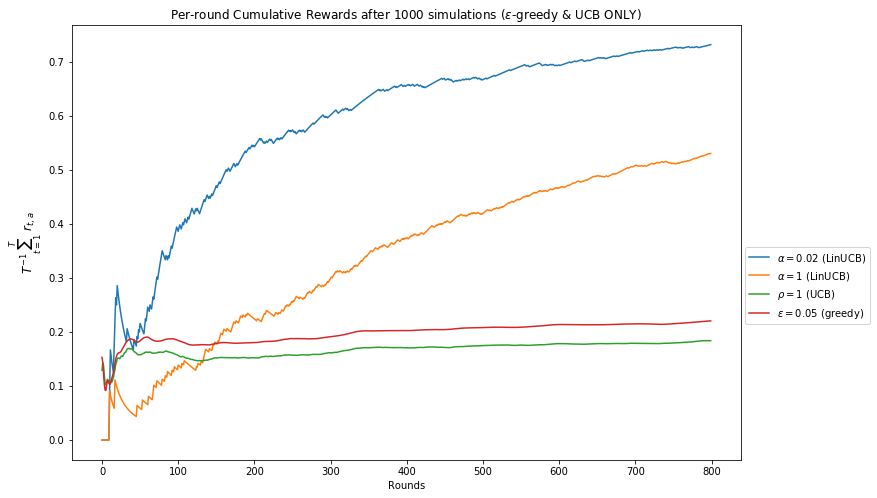

In [21]:
# build LinUCB with alpha = 0.02
mab = LinUCB(10, 10, 0.02)
results_LinUCB_02, chosen_arms_LinUCB_02, cumulative_reward_LinUCB_02 = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('Mean reward of LinUCB with alpha = 0.02 is: ', np.mean(results_LinUCB_02))

# build LinUCB with alpha = 1
mab = LinUCB(10, 10, 1)
results_LinUCB_1, chosen_arms_LinUCB_1, cumulative_reward_LinUCB_1 = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('Mean reward of LinUCB with alpha = 1 is: ', np.mean(results_LinUCB_1))

#===============================
#    Plotting results ...
#===============================

plt.figure(figsize=(12,8))
plt.plot(cumulative_reward_LinUCB_02/np.linspace(1,800,800), label = r"$\alpha=0.02$ (LinUCB)")
plt.plot(cumulative_reward_LinUCB_1/np.linspace(1,800,800), label = r"$\alpha=1$ (LinUCB)")
plt.plot(mean_UCB/(1000*np.linspace(1,800,800)), label = r"$\rho=1$ (UCB)")
plt.plot(mean_EPSgreedy/(1000*np.linspace(1,800,800)), label = r"$\epsilon=0.05$ (greedy)")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Rounds")
plt.ylabel(r"$T^{-1}\sum_{t=1}^T\ r_{t,a}$", fontsize='large')
plt.title("Per-round Cumulative Rewards after 1000 simulations " + r"($\epsilon$-greedy & UCB ONLY)")
plt.show()

## 5. KernelUCB

In [22]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [23]:
class KernelUCB(MAB):
    
    def __init__(self, narms, ndims, gamma, eta, kern):
        # Set number of arms
        self.narms = narms
        # Number of context features
        self.ndims = ndims
        # regularization parameter
        self.eta = eta
        # exploration parameter
        self.gamma = gamma
        # kernel function
        self.kern = kern
        # u_n_t values
        self.u = np.zeros(self.narms)
        # sigma_n_t values
        self.sigma = np.zeros(self.narms)
        # list of contexts of chosen actions to the moment
        self.pulled = []
        # list of rewards corresponding to chosen actions to the moment
        self.rewards = []
        # define a dictionary to store kernel matrix inverse in each tround
        self.Kinv = {}
        super().__init__()
        return
        
    def play(self, tround, context):
        self.tround = tround
        # get the flattened context and reshape it to an array of shape (narms,ndims)
        context = np.reshape(context, (self.narms,self.ndims))
        
        if self.tround == 0:
            # playing action 1 for first round and setting u_0[0] to 1.0
            self.u[0] = 1.0
        else:
            
            #========================================
            #    Calculating all possible k_x ...
            #========================================
        
            # To perform kernel UCB in the least and efficient time as possible I propose to
            # calculate k_x for all of the contexts and not just for chosen context (x_t)
            # this will be hugely beneficiary to calculating sigma_n_t step in for loop
        
            # calculate the kernel between each of the contexts of narms and the pulled 
            # contexts of chosen arms to the moment
        
            # self.pulled is just a list of arrays, and hence reshaping it to a valid
            # numpy array of shape (tround+1,ndims). Since tround is starting from zero
            # it is being added by 1 to give valid shape in each round especially for
            # the first round
            
            k_x = self.kern(context,np.reshape(self.pulled,(self.tround,self.ndims)))
            
            #===============================
            #    MAIN LOOP ...
            #===============================
            
            for i in range(self.narms):
                self.sigma[i] = np.sqrt(self.kern(context[i].reshape(1,-1),context[i].reshape(1,-1))-k_x[i].T.dot(self.Kinv[self.tround-1]).dot(k_x[i]))  
                self.u[i] = k_x[i].T.dot(self.Kinv[self.tround-1]).dot(self.y) + (self.eta/np.sqrt(self.gamma))*self.sigma[i]
            
        # tie breaking arbitrarily
        action = np.random.choice(np.where(self.u==max(self.u))[0])
        # np.argmax returns values 0-9, we want to compare with arm indices in dataset which are 1-10
        # Hence, add 1 to action before returning
        return action+1
        
    
    def update(self, arm, reward, context):
        # get the flattened context and reshape it to an array of shape (narms,ndims)
        context = np.reshape(context, (self.narms,self.ndims))
        # append the context of choesn arm (index = [arm]) with the previous list of contexts (self.pulled)
        # the obserbved context is being reshaped into a column vector simultanesously for future kernel calculations
        self.pulled.append(context[arm].reshape(1,-1))
        # set currently observed context of chosen arm as x_t
        x_t = context[arm].reshape(1,-1)
        
        #========================================
        #    Calculating all possible k_x ...
        #========================================
        
        # To perform kernel UCB in the least and efficient time as possible I propose to
        # calculate k_x for all of the contexts and not just for chosen context (x_t)
        # this will be hugely beneficiary to calculating sigma_n_t step in for loop
        
        # calculate the kernel between each of the contexts of narms and the pulled 
        # contexts of chosen arms to the moment
        
        # self.pulled is just a list of arrays, and hence reshaping it to a valid
        # numpy array of shape (tround+1,ndims). Since tround is starting from zero
        # it is being added by 1 to give valid shape in each round especially for
        # the first round
        k_x = self.kern(context,np.reshape(self.pulled,(self.tround+1,self.ndims)))
        
        # append the observed reward value of chosen action to the previous list of rewards
        self.rewards.append(reward)
        # generate array of y. Since tround is starting from zero
        # it is being added by 1 to give valid shape in each round especially for
        # the first round
        self.y = np.reshape(self.rewards,(self.tround+1,1))
        
        # building inverse of kernel matrix for first round is different from consequent rounds.
        if self.tround==0:
            self.Kinv[self.tround] = 1.0/(self.kern(x_t,x_t) + self.gamma)
        else:
            # set inverse of kernel matrix as the kernel matrix inverse of the previous round
            Kinv = self.Kinv[self.tround-1]
            # set b as k_(x_t) excluding the kernel value of the current round
            b = k_x[arm][:-1]
            # reshape b into the valid numpy column vector
            b = b.reshape(self.tround,1)
            # compute b.T.dot(kernel matrix inverse)
            bKinv = np.dot(b.T,Kinv)
            # compute (kernel matrix inverse).dot(b)
            Kinvb = np.dot(Kinv,b)
            
            #==========================================================================
            #    Calculating components of current Kernel matrix inverse (Kinv_tround)
            #==========================================================================
            
            K22 = 1.0/(k_x[arm][-1] + self.gamma - np.dot(bKinv,b))            
            K11 = Kinv + K22*np.dot(Kinvb,bKinv)
            K12 = -K22*Kinvb
            K21 = -K22*bKinv
            K11 = np.reshape(K11,(self.tround,self.tround))
            K12 = np.reshape(K12,(self.tround,1))
            K21 = np.reshape(K21,(1,self.tround))
            K22 = np.reshape(K22,(1,1))
            # stack components into an array of shape(self.tround, self.tround)
            self.Kinv[self.tround] = np.vstack((np.hstack((K11,K12)),np.hstack((K21,K22)))) 
            
        

In [24]:
mab = KernelUCB(10, 10, 1.0, 1.0, rbf_kernel)
results_KernelUCB, chosen_arms_KernelUCB, cumulative_reward_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts,800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

KernelUCB average reward 0.57375


### Performing grid search
Kernel UCB comes with two hyper-parameters including Gamma and Eta. To optimize these hyper-parameters, I propose to perform a grid search as follows, where the values of gamma will range between 0 and 10 excluding 0, and values of etas will range between 0 and +2. The results will be shown on a grid along with colorbar.

The maximum average reward is:  0.7625


Listing all possible pairs of gammas and etas yielding maximum average reward in Kernel UCB:


░░ ▒ ▒ █ █ List of Values █ █ ▒ ▒ ░░
Gamma: 	 Eta:
1.0 	 0.6000000000000001
2.5 	 0.9


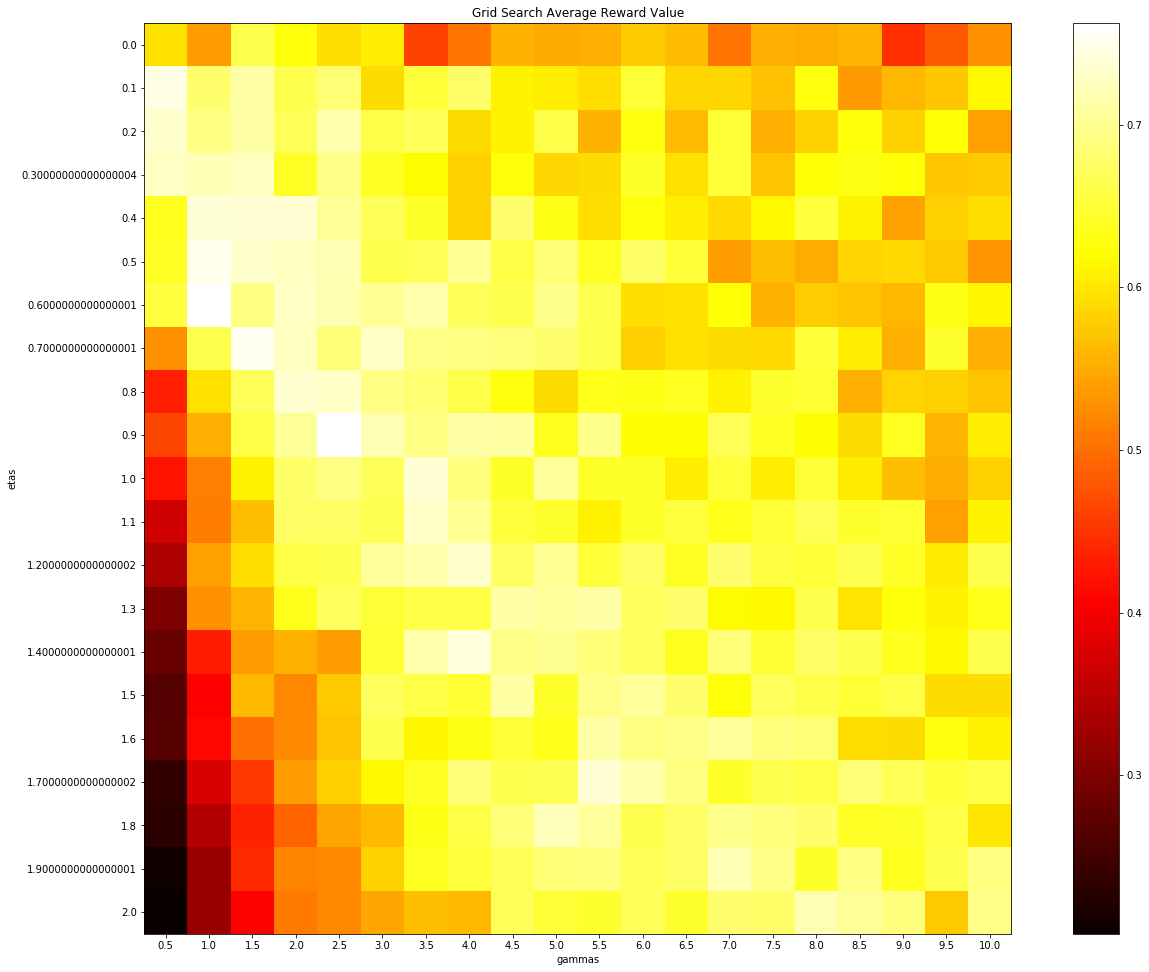

In [26]:
# arrange eta values as hyper-parameter between 0 and +2 with step of 0.1
etas = np.linspace(0,2,21)
# arrange gamma values as hyper-parameter between 0 and 10 with step of 0.5 excluding 0
gammas = np.linspace(0,10,21)[1:]
# main array to contain average reward of Kernel UCB given eta and gamma values
avg = np.zeros((len(etas),len(gammas)))

#===============================
#    Loop etas & gammas ...
#===============================

for i in range(len(etas)):
    for j in range(len(gammas)):
        mab = KernelUCB(10, 10, gammas[j], etas[i], rbf_kernel)
        results_KernelUCB, chosen_arms_KernelUCB, cumulative_reward_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
        avg[i][j] = np.mean(results_KernelUCB)

# printing the maximum average reward achieved 
print('The maximum average reward is: ', np.max(avg))

# printing list of all possible pairs of gamma and eta resulting in maximum average reward
pairs = np.where(avg==np.max(avg))
print('\n')
print('Listing all possible pairs of gammas and etas yielding maximum average reward in Kernel UCB:')
print('\n')
print('░░ ▒ ▒ █ █ List of Values █ █ ▒ ▒ ░░')
print('Gamma:', '\t', 'Eta:')
for pair in range(len(pairs[0])):
    print(gammas[pairs[1][pair]], '\t', etas[pairs[0][pair]])

#===============================
#    Plotting results ...
#===============================

plt.figure(figsize=(15, 11))
plt.subplots_adjust(left=.05, right=1.2, bottom=0.05, top=1.2)
plt.imshow(avg, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gammas')
plt.ylabel('etas')
plt.colorbar()
plt.xticks(np.arange(len(gammas)), gammas)
plt.yticks(np.arange(len(etas)), etas)
plt.title('Grid Search Average Reward Value')
plt.show()

### Implementing Kernel UCB with other kernels
Here I purpose to run Kernel UCB with chi square kernel. Hence, I will import chi2 kernel from sklearn. I will re-run the grid search for this kernel.

In [27]:
# import chi square kernel
from sklearn.metrics.pairwise import chi2_kernel

The maximum average reward is:  0.79


Listing all possible pairs of gammas and etas yielding maximum average reward in Kernel UCB:


░░ ▒ ▒ █ █ List of Values █ █ ▒ ▒ ░░
Gamma: 	 Eta:
4.5 	 1.4000000000000001


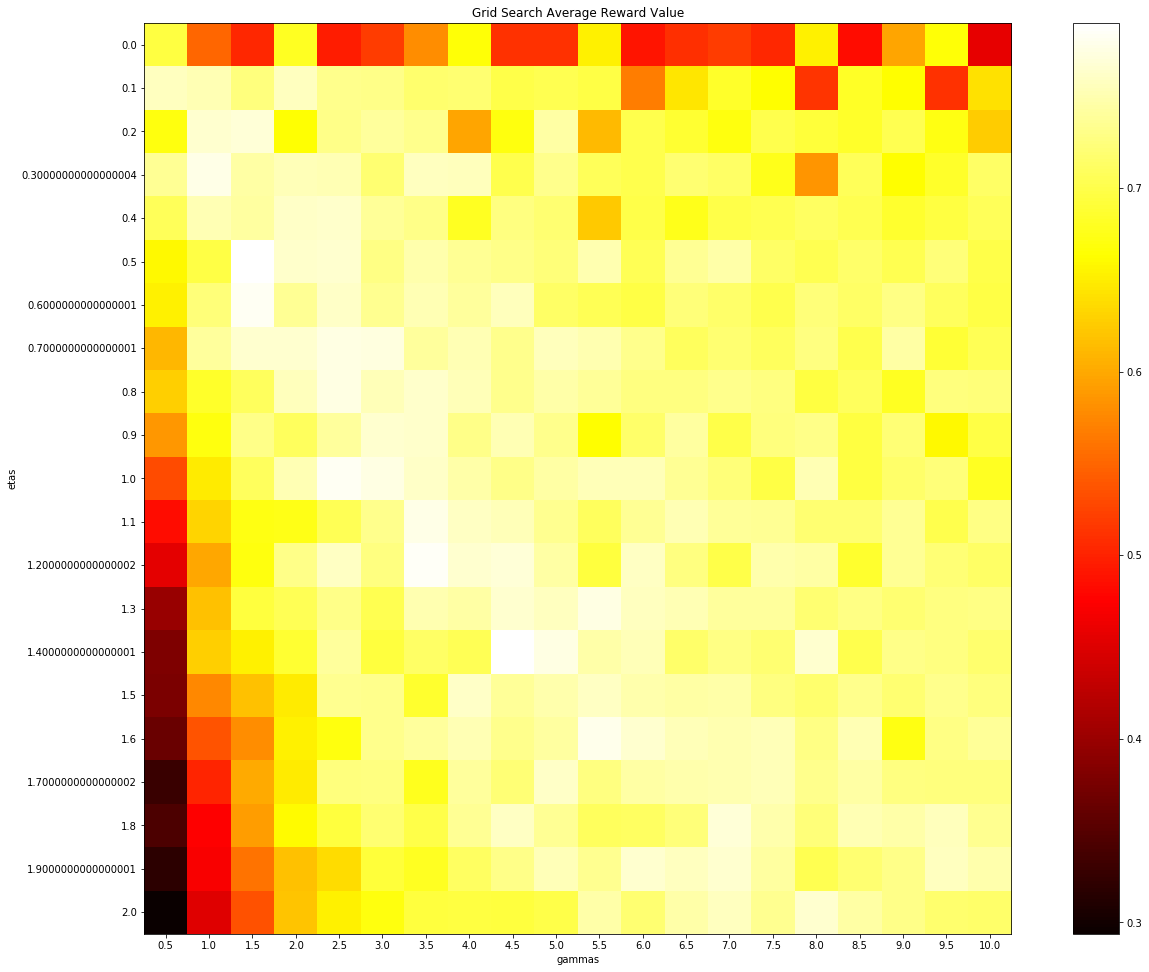

In [28]:
# arrange eta values as hyper-parameter between 0 and +2 with step of 0.1
etas = np.linspace(0,2,21)
# arrange gamma values as hyper-parameter between 0 and 10 with step of 0.5 excluding 0
gammas = np.linspace(0,10,21)[1:]
# main array to contain average reward of Kernel UCB given eta and gamma values
avg = np.zeros((len(etas),len(gammas)))

#===============================
#    Loop etas & gammas ...
#===============================

for i in range(len(etas)):
    for j in range(len(gammas)):
        mab = KernelUCB(10, 10, gammas[j], etas[i], chi2_kernel)
        results_KernelUCB, chosen_arms_KernelUCB, cumulative_reward_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
        avg[i][j] = np.mean(results_KernelUCB)

# printing the maximum average reward achieved 
print('The maximum average reward is: ', np.max(avg))

# printing list of all possible pairs of gamma and eta resulting in maximum average reward
pairs = np.where(avg==np.max(avg))
print('\n')
print('Listing all possible pairs of gammas and etas yielding maximum average reward in Kernel UCB:')
print('\n')
print('░░ ▒ ▒ █ █ List of Values █ █ ▒ ▒ ░░')
print('Gamma:', '\t', 'Eta:')
for pair in range(len(pairs[0])):
    print(gammas[pairs[1][pair]], '\t', etas[pairs[0][pair]])

#===============================
#    Plotting results ...
#===============================

plt.figure(figsize=(15, 11))
plt.subplots_adjust(left=.05, right=1.2, bottom=0.05, top=1.2)
plt.imshow(avg, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gammas')
plt.ylabel('etas')
plt.colorbar()
plt.xticks(np.arange(len(gammas)), gammas)
plt.yticks(np.arange(len(etas)), etas)
plt.title('Grid Search Average Reward Value')
plt.show()